#### iLQR for kinematic example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from ocp import *
from costs import *

%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4, suppress=True)

#### Create 2link robot 

In [2]:
dt = 0.01
T = 100
ee_id = 1
sys = TwoLinkRobot(dt = dt)
x0 = np.array([0,0,0,0])
sys.set_init_state(x0)

#set initial control output to be all zeros
us = np.zeros((T+1,sys.Du))
_ = sys.compute_matrices(x0, us[0])
xs = sys.rollout(us[:-1])

#### Plot initial trajectory

#### Set the regularization cost coefficients Q and R 

In [3]:
Q = np.eye(sys.Dx)*.1
Q[0:2,0:2] *= 0.0  #only put cost regularization on the velocity, not on the joint angles
Qf = np.eye(sys.Dx)*1
Qf[0:2,0:2] *= 0.0 #only put cost regularization on the velocity, not on the joint angles
R = np.eye(sys.Du)*.1
mu = 1e-6          #regularization coefficient

#### Set end effector target 

In [5]:
#W and WT: cost coefficients for the end-effector reaching task
p_target = np.array([.5, .8])
W = np.eye(2)*1
WT = np.eye(2)*100
sys.set_pref(p_ref)

### iLQR using cost model

#### Define the cost

In [6]:
#The costs consist of: a) state regularization (Q), b) control regularization (R), and c) End-effector reaching task (W)
#Running cost is for the time 0 <= t < T, while terminal cost is for the time t = T

runningStateCost = CostModelQuadratic(sys, Q)
runningControlCost = CostModelQuadratic(sys, None, R)
runningEECost = CostModelQuadraticTranslation(sys,W,ee_id,p_target)
runningCost = CostModelSum(sys, [runningStateCost, runningControlCost, runningEECost])

terminalStateCost = CostModelQuadratic(sys,Qf)
terminalControlCost = CostModelQuadratic(sys, None,R)
terminalEECost = CostModelQuadraticTranslation(sys,WT,ee_id,p_target)
terminalCost = CostModelSum(sys, [terminalStateCost, terminalControlCost, terminalEECost])

costs = [runningCost]*T + [terminalCost]

#### Construct ILQR

In [7]:
ilqr_cost = ILQR(sys, mu)
ilqr_cost.set_init_state(x0)
ilqr_cost.set_timestep(T)
ilqr_cost.set_cost(costs)
ilqr_cost.set_state(xs, us) #set initial trajectory

#### Solve and Plot

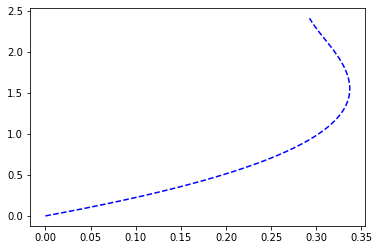

In [8]:
n_iter = 30
ilqr_cost.solve(n_iter, method='recursive')
xs_batch, us_batch = ilqr_cost.xs, ilqr_cost.us

clear_output()
plt.plot(xs_batch[:,0], xs_batch[:,1], 'b--')
plt.show()

#### Play traj

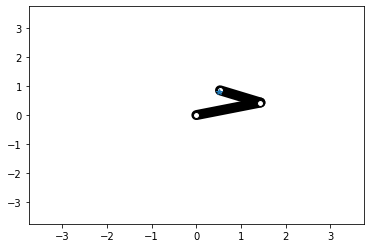

In [9]:
sys.plot_traj(ilqr_cost.xs)